In [2]:
from modules.utils_data import load_data
from modules.plotting import plot_scatter_and_line
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [3]:
%%capture
# The previous line silences the output because I don't like it

# Load the data
df_combined = load_data()

In [4]:
# Split the train/test data
train, test = train_test_split(df_combined, test_size=0.3, random_state=42)
for col in df_combined.columns[1:]:
    print(f'{col}: {test[col].count()/df_combined[col].count()}')

LogVP: 0.3108348134991119
LogP: 0.303577830357783
LogOH: 0.3352601156069364
LogBCF: 0.27884615384615385
LogHalfLife: 0.37333333333333335
BP: 0.3094054849990797
Clint: 0.2783882783882784
FU: 0.29283489096573206
LogHL: 0.3199426111908178
LogKmHL: 0.28835489833641403
LogKOA: 0.32222222222222224
LogKOC: 0.32088520055325037
MP: 0.30270770654940987
LogMolar: 0.29888803680981596


In [5]:
# Subset the train data
fraction = 0.01
out_dir = 'LogP_low_data/'
os.makedirs(out_dir, exist_ok=True)

stl_test = test[["SMILES", "LogP"]].dropna()
stl_data = train[["SMILES", "LogP"]].dropna().sample(frac=1, random_state=42) # Shuffle data
other_properties = train.drop(columns="LogP")

os.makedirs(out_dir + 'STL', exist_ok=True)
stl_less_data = stl_data[:int(len(stl_data)*fraction)]
stl_less_data.to_csv(out_dir + 'STL/train.csv', index=False)
stl_test.to_csv(out_dir + 'STL/test.csv', index=False)
print("frac", fraction, ":", len(stl_less_data))   

os.makedirs(out_dir + 'MTL', exist_ok=True)
mtl_less_data = pd.merge(stl_less_data, other_properties, on="SMILES", how="outer")
mtl_less_data.to_csv(out_dir + 'MTL/train.csv', index=False)
test.to_csv(out_dir + 'MTL/test.csv', index=False)

property_list = mtl_less_data.drop(columns='SMILES').columns.to_list()

frac 0.01 : 97


In [38]:
mtl_less_data

,SMILES,LogP,LogVP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
0,BrC(Br)(Br)Br,NaN,-0.568599,NaN,NaN,NaN,189.5,NaN,NaN,NaN,NaN,NaN,NaN,90.1,-3.140133
1,BrC(Br)(Br)c1ccc2ccccc2n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.0,NaN
2,BrC(Br)Br,NaN,0.732400,NaN,1.13,NaN,149.1,NaN,NaN,-3.271646,-0.7,NaN,2.06,8.0,-1.897436
3,BrC(Br)C(Br)(Br)Br,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.5,NaN
4,BrC(c1ccccc1)(c1ccccc1)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16254,c1nc[nH]n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16255,c1ncc2n[nH]nc2n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.231900
16256,c1ncc2nc[nH]c2n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.5,0.619400
16257,c1nnn(C23CC4CC(CC(C4)C2)C3)n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# train STL
os.system(f'''chemprop train \
--data-path "{out_dir}STL/train.csv" \
--task-type regression \
--epochs 100 \
--output-dir "{out_dir}STL/model/" \
--num-workers 15 ''')

# Predict
os.system(f'''chemprop predict \
--test-path "{out_dir}STL/test.csv" \
--model-path "{out_dir}STL/model/model_0/best.pt" \
--preds-path "{out_dir}STL/preds.csv" \
--num-workers 15''')

# train MTL
os.system(f'''chemprop train \
--data-path "{out_dir}MTL/train.csv" \
--task-type regression \
--epochs 100 \
--target-columns {" ".join(property_list)} \
--task-weights {" ".join([str(10) if p != "LogP" else str(1) for p in property_list])} \
--output-dir "{out_dir}MTL/model/" \
--num-workers 15 ''')

# Predict
os.system(f'''chemprop predict \
--test-path "{out_dir}MTL/test.csv" \
--model-path "{out_dir}MTL/model/model_0/best.pt" \
--preds-path "{out_dir}MTL/preds.csv" \
--num-workers 15''')

Wrote config file to LogP_low_data/STL/model/config.toml


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.80, got 0.79. Requested validation size of 0.10, got 0.11. Requested test size of 0.10, got 0.11. 
  warn(
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 T

Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s, v_num=0, train_loss=0.728]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s, v_num=0, train_loss=0.585, val_loss=0.787]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  6.28it/s, v_num=0, train_loss=0.430, val_loss=0.782]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s, v_num=0, train_loss=0.296, val_loss=0.769]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s, v_num=0, train_loss=0.157, val_loss=0.718]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s, v_num=0, train_loss=0.420, val_loss=0.688]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s, v_num=0, train_loss=0.258, val_loss=0.699]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=100` reached.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_low_data/STL/model/model_0/checkpoints/best-epoch=28-val_loss=0.12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_low_data/STL/model/model_0/checkpoints/best-epoch=28-val_loss=0.12.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 363.68it/s]
Entire Test Set results: {'entire_test/mse': 4.018100024347249}


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-pack

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 95.16it/s]
Wrote config file to LogP_low_data/MTL/model/config.toml


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For mor

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 128.84it/s, v_num=0, train_loss=0.103]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:01<00:00, 106.23it/s, v_num=0, train_loss=0.673, val_loss=0.396]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:01<00:00, 106.16it/s, v_num=0, train_loss=0.347, val_loss=0.423]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:01<00:00, 109.90it/s, v_num=0, train_loss=0.626, val_loss=0.416]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:01<00:00, 108.12it/s, v_num=0, train_loss=0.222, val_loss=0.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 101.12it/s, v_num=0, train_loss=0.186, val_loss=0.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:01<00:00, 104.03it/s, v_num=0, train_loss=0.318, val_loss=0.298]
Validation: |      

`Trainer.fit` stopped: `max_epochs=100` reached.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_low_data/MTL/model/model_0/checkpoints/best-epoch=78-val_loss=0.20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/rsolazzo/Digital_chemistry_benchmark/Digital_Chemistry/LogP_low_data/MTL/model/model_0/checkpoints/best-epoch=78-val_loss=0.20.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 308.24it/s]
Entire Test Set results: {'entire_test/mse': 757.093762382795}


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-pack

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 132.39it/s]


0

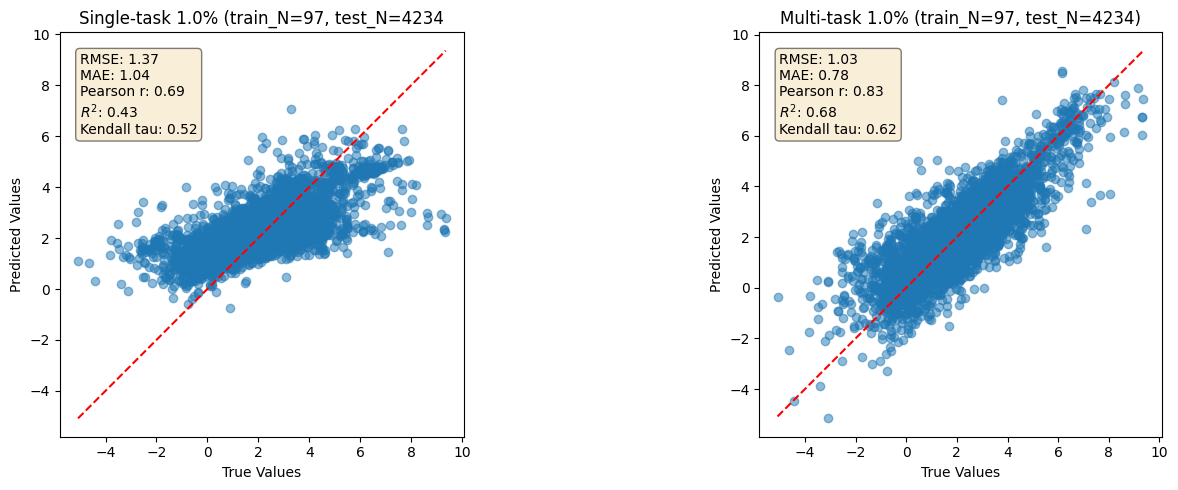

In [7]:
# Plotting results on OPERA test data

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

# Prepare data for single-task
single_task_df = pd.read_csv(out_dir + 'STL/preds_0.csv')
valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
true_single_values = valid_single["LogP"]
pred_single_values = valid_single['pred_0']

# Prepare data for multi-task
multi_task_df = pd.read_csv(out_dir + 'MTL/preds_0.csv')
valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
true_multi_values = valid_multi["LogP"]
pred_multi_values = valid_multi['pred_0']

# Plotting single-task
plot_scatter_and_line(axs[0], true_single_values, pred_single_values, f'Single-task {fraction*100}% (train_N={len(stl_less_data)}, test_N={len(valid_single)}')

# Plotting multi-task
plot_scatter_and_line(axs[1], true_multi_values, pred_multi_values, f'Multi-task {fraction*100}% (train_N={len(mtl_less_data["LogP"].dropna())}, test_N={len(valid_multi)})')

plt.tight_layout()
plt.show()

## SAMPL6 prediction

In [8]:
sampl = pd.read_csv('logP_experimental_values.csv')
sampl = sampl.rename(columns={'Isomeric SMILES': 'SMILES'})

In [9]:
smiles = sampl['SMILES']

new_df = pd.DataFrame(smiles)

columns_to_add = ['LogVP', 'LogP', 'LogOH', 'LogBCF', 'LogHalfLife', 'BP', 'Clint', 'FU', 'LogHL', 'LogKmHL', 'LogKOA', 'LogKOC', 'MP', 'LogMolar']

for column in columns_to_add:
    new_df[column] = np.nan

new_df

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
0,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c1ccc(cc1)CNc2c3ccccc3ncn2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COc1cccc(c1)Nc2c3ccccc3ncn2.Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,c1ccc(cc1)n2c3c(cn2)c(ncn3)N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)Cl.Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cc1cccc(c1)Nc2c3cc(c(cc3ncn2)OC)OC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,c1ccc(cc1)n2cnc3c2ccc(c3)N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,c1ccc2c(c1)ncn2c3ccc(cc3)O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
new_df['LogP'] = sampl['logP mean']

new_df

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
0,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,NaN,4.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,NaN,3.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c1ccc(cc1)CNc2c3ccccc3ncn2,NaN,3.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,NaN,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COc1cccc(c1)Nc2c3ccccc3ncn2.Cl,NaN,3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,c1ccc(cc1)n2c3c(cn2)c(ncn3)N,NaN,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)Cl.Cl,NaN,3.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cc1cccc(c1)Nc2c3cc(c(cc3ncn2)OC)OC,NaN,2.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,c1ccc(cc1)n2cnc3c2ccc(c3)N,NaN,1.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,c1ccc2c(c1)ncn2c3ccc(cc3)O,NaN,3.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
new_df.to_csv('sampl_logP.csv', index=False)

In [12]:
# Predict using STL model
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path "{out_dir}STL/model/model_0/best.pt" \
--preds-path "SAMPL_STL_preds.csv" \
--num-workers 15''')

# Predict using MTL model
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path "{out_dir}MTL/model/model_0/best.pt" \
--preds-path "SAMPL_MTL_preds.csv" \
--num-workers 15''')

/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For mor

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/rsolazzo/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For mor

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


0

In [13]:
results_mtl = pd.read_csv('SAMPL_MTL_preds_0.csv')
results_stl = pd.read_csv('SAMPL_STL_preds_0.csv')

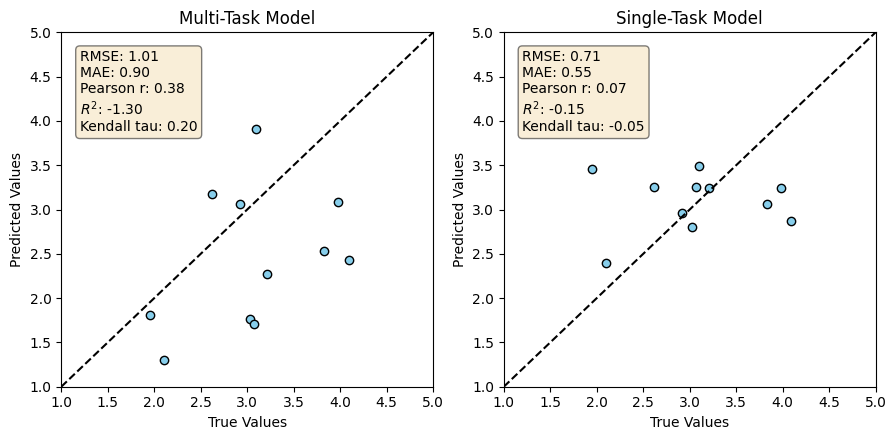

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, kendalltau

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

# Set axis limits
xlim = ylim = (1, 5)

# First scatter plot
axs[0].scatter(results_mtl['LogP'], results_mtl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
# Add diagonal line
axs[0].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_mtl['LogP'], results_mtl['pred_0']))
mae = mean_absolute_error(results_mtl['LogP'], results_mtl['pred_0'])
r, _ = pearsonr(results_mtl['LogP'], results_mtl['pred_0'])
r2 = r2_score(results_mtl['LogP'], results_mtl['pred_0'])
tau, _ = kendalltau(results_mtl['LogP'], results_mtl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Multi-Task Model')

# Second scatter plot
axs[1].scatter(results_stl['LogP'], results_stl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
# Add diagonal line
axs[1].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_stl['LogP'], results_stl['pred_0']))
mae = mean_absolute_error(results_stl['LogP'], results_stl['pred_0'])
r, _ = pearsonr(results_stl['LogP'], results_stl['pred_0'])
r2 = r2_score(results_stl['LogP'], results_stl['pred_0'])
tau, _ = kendalltau(results_stl['LogP'], results_stl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Single-Task Model')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
